# Using PyTorch for simple regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/2.pytorch-nn-training-cars.ipynb)

## Support code

In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

def mshow(model, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

## Load simple data set

In [3]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

Epoch   0 MSE loss      604.035 MAE    23.42
Epoch  10 MSE loss      207.753 MAE    13.62
Epoch  20 MSE loss       45.364 MAE     5.48
Epoch  30 MSE loss       19.641 MAE     3.39
Epoch  40 MSE loss       24.351 MAE     4.01
Epoch  50 MSE loss       21.547 MAE     3.72
Epoch  60 MSE loss       18.813 MAE     3.32
Epoch  70 MSE loss       18.828 MAE     3.28
LAST      MSE loss       18.828 MAE     3.28


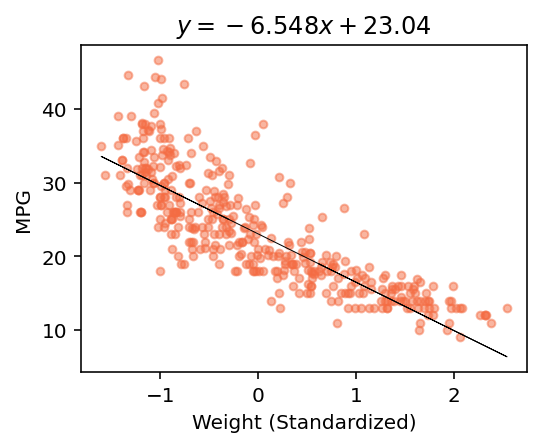

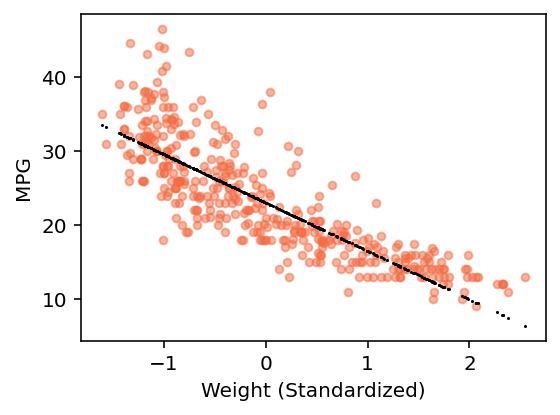

In [5]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)
mshow(model, X=X, y=df_cars.MPG)

## Factor out a training method

In [6]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

Epoch    0 MSE loss      625.181 MAE    23.92
Epoch    7 MSE loss      307.446 MAE    16.99
Epoch   14 MSE loss      132.403 MAE    10.49
Epoch   21 MSE loss       42.441 MAE     5.21
Epoch   28 MSE loss       20.275 MAE     3.28
Epoch   35 MSE loss       21.244 MAE     3.68
Epoch   42 MSE loss       24.249 MAE     4.01
Epoch   49 MSE loss       22.266 MAE     3.81
Epoch   56 MSE loss       19.716 MAE     3.47
Epoch   63 MSE loss       18.723 MAE     3.31
Epoch   70 MSE loss       18.780 MAE     3.27
LAST       MSE loss       18.780 MAE     3.27


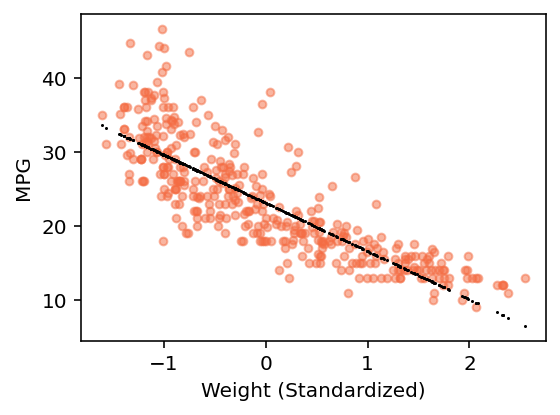

In [7]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=70)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

### Without nonlinearity

Epoch    0 MSE loss      642.335 MAE    24.11
Epoch   10 MSE loss       67.511 MAE     7.02
Epoch   20 MSE loss       24.205 MAE     3.96
Epoch   30 MSE loss       20.570 MAE     3.35
Epoch   40 MSE loss       21.315 MAE     3.67
Epoch   50 MSE loss       19.079 MAE     3.25
Epoch   60 MSE loss       18.823 MAE     3.25
Epoch   70 MSE loss       18.780 MAE     3.30
Epoch   80 MSE loss       18.701 MAE     3.27
Epoch   90 MSE loss       18.684 MAE     3.29
Epoch  100 MSE loss       18.677 MAE     3.28
LAST       MSE loss       18.677 MAE     3.28


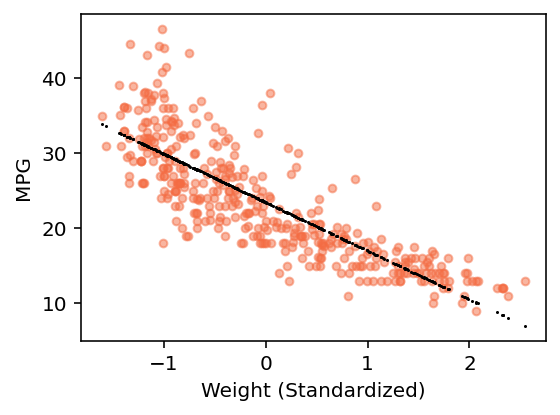

In [8]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      570.653 MAE    22.58
Epoch   10 MSE loss       37.147 MAE     4.87
Epoch   20 MSE loss       39.198 MAE     5.53
Epoch   30 MSE loss       22.941 MAE     3.60
Epoch   40 MSE loss       19.050 MAE     3.26
Epoch   50 MSE loss       18.367 MAE     3.25
Epoch   60 MSE loss       17.886 MAE     3.16
Epoch   70 MSE loss       17.859 MAE     3.12
Epoch   80 MSE loss       17.776 MAE     3.12
Epoch   90 MSE loss       17.767 MAE     3.13
Epoch  100 MSE loss       17.758 MAE     3.14
LAST       MSE loss       17.758 MAE     3.14


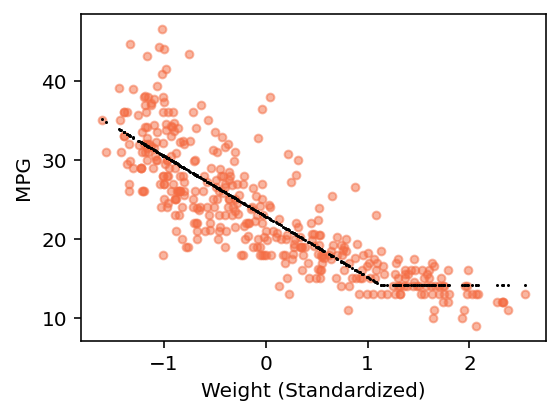

In [9]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      587.965 MAE    22.98
Epoch   10 MSE loss       43.836 MAE     5.30
Epoch   20 MSE loss       36.838 MAE     5.03
Epoch   30 MSE loss       21.283 MAE     3.35
Epoch   40 MSE loss       18.805 MAE     3.28
Epoch   50 MSE loss       18.725 MAE     3.35
Epoch   60 MSE loss       18.340 MAE     3.24
Epoch   70 MSE loss       18.317 MAE     3.23
Epoch   80 MSE loss       18.243 MAE     3.22
Epoch   90 MSE loss       18.198 MAE     3.22
Epoch  100 MSE loss       18.169 MAE     3.22
LAST       MSE loss       18.169 MAE     3.22


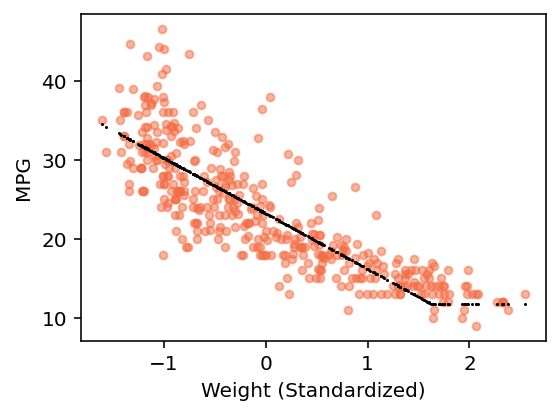

In [10]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      592.965 MAE    23.07
Epoch   10 MSE loss      450.138 MAE    19.73
Epoch   20 MSE loss      199.519 MAE    11.82
Epoch   30 MSE loss       60.771 MAE     6.55
Epoch   40 MSE loss       80.753 MAE     7.63
Epoch   50 MSE loss       60.833 MAE     6.53
Epoch   60 MSE loss       63.396 MAE     6.54
Epoch   70 MSE loss       60.779 MAE     6.55
Epoch   80 MSE loss       61.073 MAE     6.58
Epoch   90 MSE loss       60.796 MAE     6.54
Epoch  100 MSE loss       60.784 MAE     6.54
LAST       MSE loss       60.784 MAE     6.54


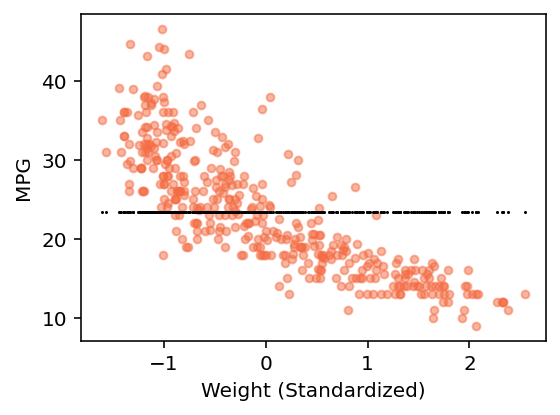

In [11]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### What matrix algebra is that model doing?

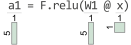

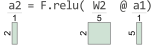

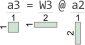

In [12]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      606.693 MAE    23.37
Epoch   10 MSE loss      169.291 MAE     9.88
Epoch   20 MSE loss       81.890 MAE     7.68
Epoch   30 MSE loss       61.864 MAE     6.52
Epoch   40 MSE loss       61.588 MAE     6.52
Epoch   50 MSE loss       61.692 MAE     6.64
Epoch   60 MSE loss       60.841 MAE     6.52
Epoch   70 MSE loss       60.121 MAE     6.52
Epoch   80 MSE loss       53.180 MAE     6.10
Epoch   90 MSE loss       39.229 MAE     5.05
Epoch  100 MSE loss       32.734 MAE     4.52
LAST       MSE loss       32.734 MAE     4.52


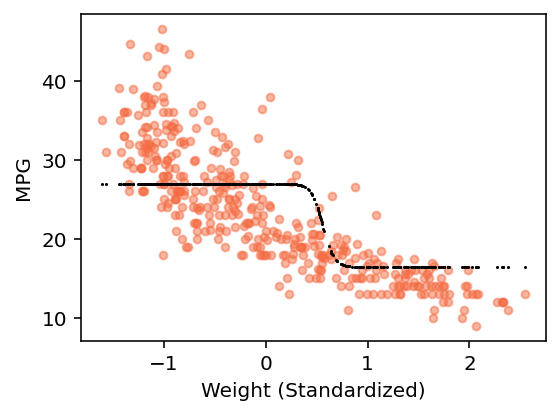

In [29]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      618.484 MAE    23.61
Epoch  200 MSE loss       17.139 MAE     3.04
Epoch  400 MSE loss       16.921 MAE     3.03
Epoch  600 MSE loss       16.702 MAE     3.02
Epoch  800 MSE loss       16.656 MAE     3.02
Epoch 1000 MSE loss       16.577 MAE     3.01
Epoch 1200 MSE loss       16.550 MAE     3.00
Epoch 1400 MSE loss       16.570 MAE     3.01
Epoch 1600 MSE loss       16.705 MAE     2.96
Epoch 1800 MSE loss       16.523 MAE     2.98
Epoch 2000 MSE loss       16.711 MAE     2.95
LAST       MSE loss       16.711 MAE     2.95


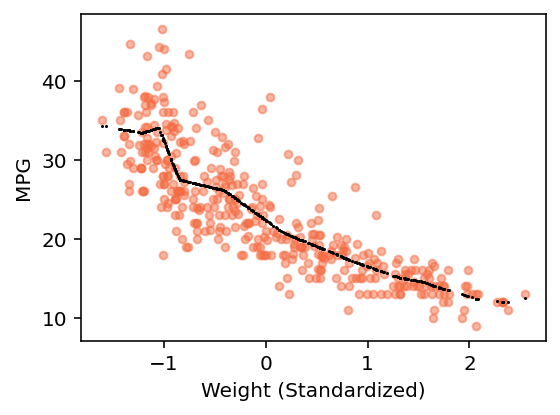

In [14]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      603.665 MAE    23.33
Epoch  150 MSE loss       17.308 MAE     3.06
Epoch  300 MSE loss       23.248 MAE     3.74
Epoch  450 MSE loss       17.261 MAE     3.05
Epoch  600 MSE loss       17.246 MAE     3.05
Epoch  750 MSE loss       17.233 MAE     3.05
Epoch  900 MSE loss       17.107 MAE     3.03
Epoch 1050 MSE loss       16.968 MAE     3.01
Epoch 1200 MSE loss       16.866 MAE     3.00
Epoch 1350 MSE loss       16.775 MAE     2.99
Epoch 1500 MSE loss       19.199 MAE     3.37
LAST       MSE loss       19.199 MAE     3.37


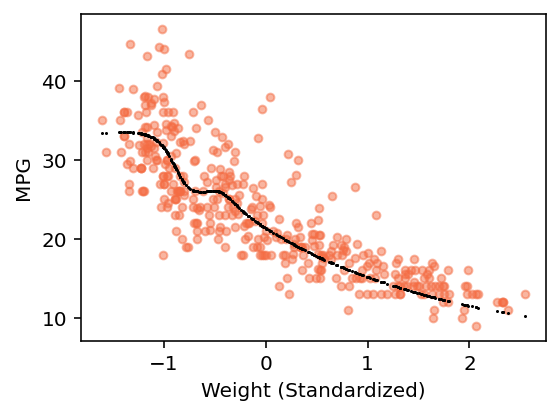

In [15]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)